<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#install-pre-requisite" data-toc-modified-id="pre-requisite"><span class="toc-item-num">Install Pre-Requisite</a></span></li><li><span><a href="#Load-Libraries" data-toc-modified-id="Load-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Libraries</a></span></li><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Trains" data-toc-modified-id="Trains-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Trains</a></span></li><li><span><a href="#The-Infrastructure" data-toc-modified-id="The-Infrastructure-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The Infrastructure</a></span><ul class="toc-item"><li><span><a href="#The-Base-Class" data-toc-modified-id="The-Base-Class-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>The Base Class</a></span></li><li><span><a href="#Depots" data-toc-modified-id="Depots-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Depots</a></span></li><li><span><a href="#Cross-Over-Points" data-toc-modified-id="Cross-Over-Points-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Cross Over Points</a></span></li><li><span><a href="#Stations" data-toc-modified-id="Stations-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Stations</a></span></li></ul></li><li><span><a href="#The-Network" data-toc-modified-id="The-Network-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>The Network</a></span></li><li><span><a href="#Utilities" data-toc-modified-id="Utilities-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Utilities</a></span></li><li><span><a href="#System-Verification" data-toc-modified-id="System-Verification-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>System Verification</a></span><ul class="toc-item"><li><span><a href="#Reference-Simulation" data-toc-modified-id="Reference-Simulation-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Reference Simulation</a></span></li><li><span><a href="#Simulating-an-Incident" data-toc-modified-id="Simulating-an-Incident-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Simulating an Incident</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>References</a></span></li></ul></div>

In [0]:
!pip install simpy

In [0]:
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import random 
import math
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
import simpy
from simpy import events as evt

#Prepare Data

In [0]:
dt=pd.read_csv('/content/TrainSchedule.xls')
df = pd.DataFrame({'train_number' : [], 'signal_count':[], 'London Euston':[], 'London Old Oak':[], 'Birmingham Interchange':[], 'Birmingham Curzon':[], 'travel_time':[]})

In [458]:
dt.head()

,Line,From,To,Distance,Running Time,Signal Blocks
0,HS2,London Euston,London Old Oak,23,5,1
1,HS2,London Old Oak,Birmingham Interchange,145,30,14
2,HS2,Birmingham Interchange,Birmingham Curzon,42,9,2


#Convert distances to meters

In [0]:
dt['Distance']=dt['Distance'].apply(lambda x: int(x*1000))

In [460]:
dt.head()

,Line,From,To,Distance,Running Time,Signal Blocks
0,HS2,London Euston,London Old Oak,23000,5,1
1,HS2,London Old Oak,Birmingham Interchange,145000,30,14
2,HS2,Birmingham Interchange,Birmingham Curzon,42000,9,2


#Convert Time into Seconds

In [0]:
dt['Running Time']=dt['Running Time'].apply(lambda x: int(x*60))

In [462]:
dt.head()

,Line,From,To,Distance,Running Time,Signal Blocks
0,HS2,London Euston,London Old Oak,23000,300,1
1,HS2,London Old Oak,Birmingham Interchange,145000,1800,14
2,HS2,Birmingham Interchange,Birmingham Curzon,42000,540,2


#Method to convert time into seconds

In [0]:
def parseTime(s):
    if isinstance(s, str):
        parts=s.split(':')
        if len(parts)>=2:
            hours=int(parts[0])
            minutes=int(parts[1])
            seconds=0 if len(parts)==2 else int(parts[2])
            return 3600*hours+60*minutes+seconds
    # any wrong formats will be passed through and may cause 
    # an error at a later stage
    return s

# Trains

In [0]:
class Train(object): 
    def __init__(self, env, that):
        self.env = env
        self.that = that;

    def logTainSchedule(self):
      

    def process(self, train_no, wait_time):
      """ Train Process, {delay=60} we assume train will stop for a minute in everyt station."""
      
      train_name = '[Train Number - '+f"{train_no:2d}"+']'
      here = self.that.stations()[0]       
      index = 0
      for station in self.that.stations()[1:]:
          data=dt[dt['From']==here]
          runTime=data.iloc[0].at['Running Time']
          no_of_block = data.iloc[0].at['Signal Blocks']
          drive = runTime/no_of_block
          if wait_time:
            print(f"{self.that.currentTime():s} waiting....")
            yield self.env.timeout(wait_time)
            print(f"{self.that.currentTime():s} Resume....")

          print(f"{self.that.currentTime():s} {train_name:s} dep {here:s} for {station:s}")

          for sig in self.that.blocks()[index]:
              with sig.request() as req:
                  yield req        
                  yield self.env.timeout(drive)                  
                  here=station                  
                  print(f"{self.that.currentTime():s} {train_name:s} arr {here:s}")
          index+=1

In [0]:
class Network(object):
    def __init__(self, start, end, interval, train_count, wait_time):
      self.start = parseTime(start)
      self.stop = parseTime(end)
      self.interval = interval
      self.env=simpy.Environment()
      self.train = Train(self.env, self)
      self.t_count = train_count
      self.w_time = wait_time

    def stations(self):
      """ station name from list. """
      stations=dt['From'].to_list()
      stations+=[dt['To'].to_list() [-1]]
      return stations    

    def formattedSystemTime(self, time):
         time=int(time)
         return f"{time//3600:02d}:{(time%3600)//60:02d}:{time%60:02d}"

    def currentTime(self):
        return self.formattedSystemTime(self.env.now)
    
    def updateSignalCount(self, count):
        dt['Signal Blocks'][1] = count

    def incident(self, wait_time):
      """" Incident wait time """
      if wait_time:
        return wait_time
      else:
        return 0

    def trainCount(self, train_count):
      if train_count:
        return train_count
      else:
        return int((self.stop-self.start)/self.interval)

    def process(self): 
      """ Starting Train simulatin process."""     
      yield self.env.timeout(self.start-self.env.now) 
      for train_no in range(self.trainCount(self.t_count)):          
          self.env.process(self.train.process(train_no, self.incident(self.w_time)))
          yield self.env.timeout(self.interval)

    def blocks(self):
      """ Signaling Block between station. creating resource as signaling block."""
      blocks_list = []
      here = self.stations()[0]

      for dest in self.stations()[1:]:
          dest_blocks = []
          desRow = dt[dt['From'] == here]
          no_of_blocks = desRow.iloc[0].at['Signal Blocks']
          for i in range(no_of_blocks):
              b = simpy.Resource(self.env, capacity=1)
              dest_blocks.append(b)
              
          blocks_list.append(dest_blocks)
          here=dest
      return blocks_list

    def runSimulation(self):
      """ starting process. """
      self.env.process(self.process())
      self.env.run()

#Simulation

In [466]:
network=Network("06:00", "07:00", 180, None, None)
network.runSimulation()

06:00:00 [Train Number -  0] dep London Euston for London Old Oak
06:03:00 [Train Number -  1] dep London Euston for London Old Oak
06:05:00 [Train Number -  0] arr London Old Oak
06:05:00 [Train Number -  0] dep London Old Oak for Birmingham Interchange
06:06:00 [Train Number -  2] dep London Euston for London Old Oak
06:07:08 [Train Number -  0] arr Birmingham Interchange
06:08:00 [Train Number -  1] arr London Old Oak
06:08:00 [Train Number -  1] dep London Old Oak for Birmingham Interchange
06:09:00 [Train Number -  3] dep London Euston for London Old Oak
06:09:17 [Train Number -  0] arr Birmingham Interchange
06:10:08 [Train Number -  1] arr Birmingham Interchange
06:11:00 [Train Number -  2] arr London Old Oak
06:11:00 [Train Number -  2] dep London Old Oak for Birmingham Interchange
06:11:25 [Train Number -  0] arr Birmingham Interchange
06:12:00 [Train Number -  4] dep London Euston for London Old Oak
06:12:17 [Train Number -  1] arr Birmingham Interchange
06:13:08 [Train Numbe

In [467]:
dt.head()

,Line,From,To,Distance,Running Time,Signal Blocks
0,HS2,London Euston,London Old Oak,23000,300,1
1,HS2,London Old Oak,Birmingham Interchange,145000,1800,14
2,HS2,Birmingham Interchange,Birmingham Curzon,42000,540,2


#Optimisation

Simulation 

numbers of trains per hour n ∈ {1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20}

signalling blocks k ∈ {1, ..., 15} 

In [0]:
def simulateBlockWithTrain():
  train_per_hour = [1] 
  
  for train_count in train_per_hour:     
    for signal_count in range(1, 13):  
      network=Network("06:00", "07:00", 180, train_count, None)
      network.updateSignalCount(signal_count)
      network.runSimulation()

In [469]:
simulateBlockWithTrain()

06:00:00 [Train Number -  0] dep London Euston for London Old Oak
06:05:00 [Train Number -  0] arr London Old Oak
06:05:00 [Train Number -  0] dep London Old Oak for Birmingham Interchange
06:35:00 [Train Number -  0] arr Birmingham Interchange
06:35:00 [Train Number -  0] dep Birmingham Interchange for Birmingham Curzon
06:39:30 [Train Number -  0] arr Birmingham Curzon
06:44:00 [Train Number -  0] arr Birmingham Curzon
06:00:00 [Train Number -  0] dep London Euston for London Old Oak
06:05:00 [Train Number -  0] arr London Old Oak
06:05:00 [Train Number -  0] dep London Old Oak for Birmingham Interchange
06:20:00 [Train Number -  0] arr Birmingham Interchange
06:35:00 [Train Number -  0] arr Birmingham Interchange
06:35:00 [Train Number -  0] dep Birmingham Interchange for Birmingham Curzon
06:39:30 [Train Number -  0] arr Birmingham Curzon
06:44:00 [Train Number -  0] arr Birmingham Curzon
06:00:00 [Train Number -  0] dep London Euston for London Old Oak
06:05:00 [Train Number -  0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#Minimise the overall average traveling time

In [454]:
def MinimizeOverAllTime():
  train_per_hour = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20]   
  for train_count in train_per_hour: 
    wait_time = int(30/train_count)
    print("wait_time", wait_time)
    for signal_count in range(1, 13):  
      network=Network("06:00", "07:00", 180, train_count, wait_time)
      network.updateSignalCount(signal_count)
      network.runSimulation()
MinimizeOverAllTime()

wait_time 30
06:00:00 waiting....
06:00:30 Resume....
06:00:30 [Train Number -  0] dep London Euston for London Old Oak
06:05:30 [Train Number -  0] arr London Old Oak
06:05:30 waiting....
06:06:00 Resume....
06:06:00 [Train Number -  0] dep London Old Oak for Birmingham Interchange
06:36:00 [Train Number -  0] arr Birmingham Interchange
06:36:00 waiting....
06:36:30 Resume....
06:36:30 [Train Number -  0] dep Birmingham Interchange for Birmingham Curzon
06:41:00 [Train Number -  0] arr Birmingham Curzon
06:45:30 [Train Number -  0] arr Birmingham Curzon
06:00:00 waiting....
06:00:30 Resume....
06:00:30 [Train Number -  0] dep London Euston for London Old Oak
06:05:30 [Train Number -  0] arr London Old Oak
06:05:30 waiting....
06:06:00 Resume....
06:06:00 [Train Number -  0] dep London Old Oak for Birmingham Interchange
06:21:00 [Train Number -  0] arr Birmingham Interchange
06:36:00 [Train Number -  0] arr Birmingham Interchange
06:36:00 waiting....
06:36:30 Resume....
06:36:30 [Train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Streaming output truncated to the last 5000 lines.
06:36:42 [Train Number -  6] arr Birmingham Interchange
06:36:58 [Train Number -  7] arr Birmingham Interchange
06:37:14 [Train Number -  8] arr Birmingham Interchange
06:37:31 [Train Number -  9] arr Birmingham Interchange
06:37:47 [Train Number - 10] arr Birmingham Interchange
06:38:02 [Train Number - 11] arr London Old Oak
06:38:02 waiting....
06:38:04 Resume....
06:38:04 [Train Number - 11] dep London Old Oak for Birmingham Interchange
06:38:04 [Train Number -  1] arr Birmingham Interchange
06:38:04 waiting....
06:38:06 Resume....
06:38:06 [Train Number -  1] dep Birmingham Interchange for Birmingham Curzon
06:38:20 [Train Number -  2] arr Birmingham Interchange
06:38:36 [Train Number -  3] arr Birmingham Interchange
06:38:53 [Train Number -  4] arr Birmingham Interchange
06:39:00 waiting....
06:39:02 Resume....
06:39:02 [Train Number - 13] dep London Euston for London Old Oak
06:39:09 [Train Number -  5] arr Birmingham Interchange

#Calculate  (nopt, kopt) 

#Maximise the throughput of passengers in peak hours using  Poisson-Distribution

In [0]:
def  PoissonDistribution(λ=None, N=None, T=None,
                  plot=True, events=None, figsize=None):
    
    if events!=None:
        N = len(events)
        
    if N!=None and T==None and λ!=None:
        T = int(N/λ)
    elif N==None and T!=None and λ!=None:
        N = int(λ*T)
    elif N!=None and T!=None and λ==None:
        λ = N/T
        
    if events==None:
        u = [ random.uniform(0, 1) for i in range(N) ]
        P = list(np.cumsum(list(map(
                 lambda x: -math.log(1-x)/λ, u))))
    else:
        P = events
        
    if plot:
        
        if figsize!=None:
            width, height = figsize
        else:
            width, height = 10, 6
            
        fig, ax=plt.subplots(1,1)
        fig.set_figwidth(width)
        fig.set_figheight(height)
        
        def X(l):
            
            xmax = max(int(N/λ), math.ceil(max(l)))
            
            def double(l):
                return [] if l==[] \
                         else [l[0], l[0]]+double(l[1:])
            
            return [0]+double(l)+[xmax]
        
        def Y(l):
            
            def steps(l, n):
                return [] if l==[] \
                        else [n, n]+steps(l[1:], n+1)
            
            return [0, 0]+steps(l, 1)
        
        x = X(P)
        y = Y(P)
        
        ax.set_title(f"Poisson Process λ={λ:5.3f} n={N:d}")
        ax.set_xlim(min(x), max(x))
        ax.set_ylim(min(y), max(y))
        ax.yaxis.set_major_locator(
            mpl.ticker.MaxNLocator(integer=True))
        ax.plot(x, y, lw=3)
        ax.plot(x, list(map(lambda x:λ*x, x)))
        ax.grid(True)
        
    return P


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3953b1b5c0>]],
      dtype=object)

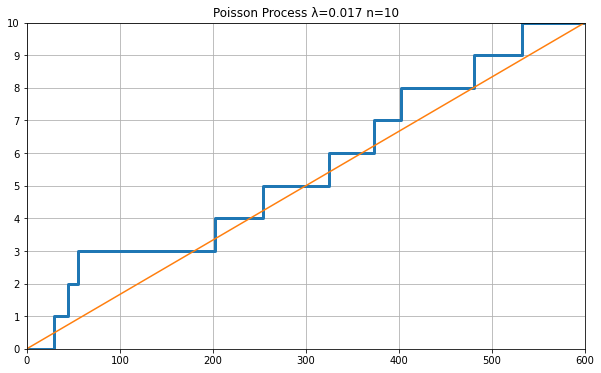

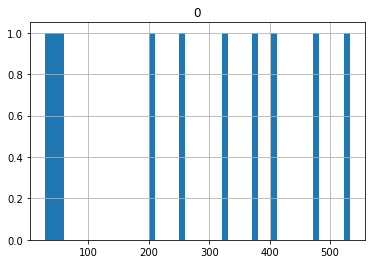

In [445]:
random.seed(41)
failure = PoissonDistribution(λ=1/60, N=10, plot=True)
failure = pd.DataFrame(failure) 
failure.mean()
failure.hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f39555726d8>]],
      dtype=object)

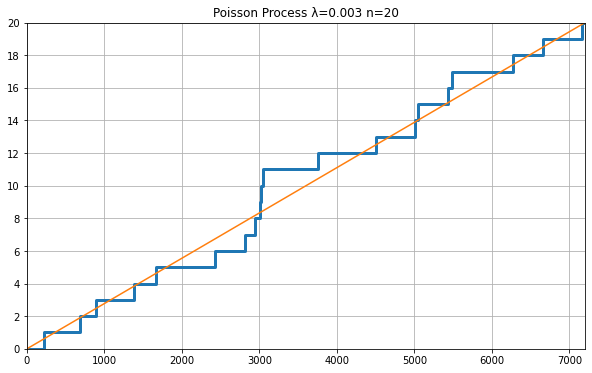

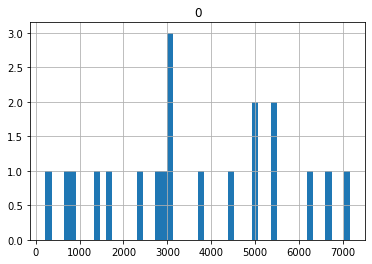

In [456]:
cus = PoissonDistribution(λ=10/3600, N=20, plot=True)
cus = pd.DataFrame(cus) 
cus.mean()
cus.hist(bins=50)